Реализация базовой модели.

Проводил небольшой подбор гиперпараметров: менял размер эмбединга и скрытого слоя. Остановился на тех гиперпараметрах, которые указаны ниже при объявлении модели. Модель достаточно быстро выходит на плато по лоссу, но BLEU на валидационной выборке все равно после этого продолжает увеличиваться. Только в районе 60 эпох BLEU тоже выходит на плато.

Дропаут не уменьшал, т.к. модель переобучается (но при этом не сильно и только в самом конце).

Леарнинг рейт не трогал, т.к. как модель достаточно быстро обучалась при 0.001. В ноутбуке Seq2Seq_lr_sched попробовал менять lr и использовать шедьюлер. Там можно посмотреть и результаты.

Итог: Достиг BLEU на валидационной выборке 22.9.

# Импортируем библиотеки

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

import torchtext
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import vocab
from nltk.tokenize import wordpunct_tokenize
from nltk.translate.bleu_score import corpus_bleu

import tqdm
import os
import numpy as np
import pandas as pd
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

/opt/calculation/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing

In [2]:
I = 0

path_to_data = '../data.txt'

MAX_SEQUENCE_LENGTH = 50
BATCH_SIZE = 128

SAVE_DIR = 'check_points/'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

torch.manual_seed(42)

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [3]:
# Step 1: Read the dataset file and parse it
def read_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    english_sentences = []
    russian_sentences = []
    for line in lines:
        english, russian = line.strip().split('\t')
        english_sentences.append(english)
        russian_sentences.append(russian)
    return english_sentences, russian_sentences

english_sentences, russian_sentences = read_dataset(path_to_data)

# Step 2: Tokenize the sentences
def tokenize_sentences(sentences):
    tokenized_sentences = [wordpunct_tokenize(sentence.lower()) for sentence in sentences]
    return tokenized_sentences

english_tokenized = tokenize_sentences(english_sentences)
russian_tokenized = tokenize_sentences(russian_sentences)

In [4]:
print('Размер корпуса:', len(russian_sentences))
print(russian_sentences[0])
print(english_sentences[0])

Размер корпуса: 50000
Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.
Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.


In [5]:
# Step 3: Create vocabulary mappings
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    vocab = torchtext.vocab.vocab(counter, min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

english_vocab = build_vocab(english_tokenized)
russian_vocab = build_vocab(russian_tokenized)

In [6]:
INPUT_DIM = len(russian_vocab)
OUTPUT_DIM = len(english_vocab)
PAD_IDX = english_vocab['<PAD>']
SOS_IDX = english_vocab['<SOS>']
EOS_IDX = english_vocab['<EOS>']
UNK_IDX = english_vocab['<UNK>']

In [7]:
print(len(english_vocab))
print(len(russian_vocab))

7828
10799


In [8]:
# Step 4: Convert tokenized sentences into sequences of integer indices
def sentence_to_indices(tokenized_sentences, vocab):
    indices = [[vocab['<SOS>']] + [vocab[token] for token in sentence] + [vocab['<EOS>']] for sentence in tokenized_sentences]
    return indices

english_indices = sentence_to_indices(english_tokenized, english_vocab)
russian_indices = sentence_to_indices(russian_tokenized, russian_vocab)

In [9]:
# Step 5: Pad sequences to a fixed length
def pad_sequences(indices, max_length, padding_idx):
    padded_indices = [sentence[:max_length] + [padding_idx] * (max_length - len(sentence)) for sentence in indices]
    return torch.tensor(padded_indices)

english_padding_idx = english_vocab['<PAD>']
russian_padding_idx = russian_vocab['<PAD>']
english_padded = pad_sequences(english_indices, MAX_SEQUENCE_LENGTH, english_padding_idx)
russian_padded = pad_sequences(russian_indices, MAX_SEQUENCE_LENGTH, russian_padding_idx)

In [10]:
# Step 6: Split the dataset into training and validation sets
dataset = list(zip(russian_padded, english_padded))
train_size = int(0.8 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

## Определение классов модели

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True,
                          num_layers=n_layers, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded)
        return hidden

In [12]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True,
                          num_layers=n_layers, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded, hidden)
        output = self.out(output)
        return output, hidden

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input, target_tensor=None):
        encoder_hidden = self.encoder(input)

        seq_length = MAX_SEQUENCE_LENGTH
        if target_tensor is not None:
            seq_length = target_tensor.shape[1]

        decoder_input = torch.empty(input.shape[0], 1, dtype=torch.long, device=DEVICE).fill_(SOS_IDX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(1, seq_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

## Дополнительные функции

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
def train(model, optimizer, criterion, clip, lr_scheduler=None, n_show = 50,
                train_history=[], valid_history=[], bleu_history=[]):
    model.train()

    epoch_loss = 0
    I_val = []
    epoch_history = []
    val_history = []
    nf_val_history = []
    bleu_scores = []
    for i, batch in tqdm.tqdm(enumerate(train_loader)):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)

        optimizer.zero_grad()

        output = model(src, trg)
        output = output.view(-1, output.shape[-1])
        trg_output = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg_output)
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if lr_scheduler is not None: lr_scheduler.step()

        epoch_loss += loss.item()

        epoch_history.append(loss.detach().cpu().data.numpy())
        
        if (i+1) % n_show == 0:
            I_val.append(i)
            val_history.append(evaluate(model, val_loader, criterion))
            
            bleu_score, _1, _2 = calc_bleu(model, val_loader)
            bleu_scores.append(bleu_score)
            
            model.train()
            
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    
            line_11, = ax[0].plot(epoch_history, label='train loss')
            line_12, = ax[0].plot(I_val, val_history, label='val loss')
            # line_13, = ax[0].plot(I_val, nf_val_history, label='no force val loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Loss')
            ax[0].legend()
            
            if train_history != []:
                ax[1].plot(train_history, label='Train loss')
            if valid_history != []:
                ax[1].plot(valid_history, label='Valid loss')
            ax[1].legend()
            ax[1].set_xlabel('# of epoch')
            ax[1].set_title('Loss')
            
            if bleu_history != []:
                ax[2].plot(bleu_history, label='Validation BLEU' )
                ax[1].set_xlabel('# of epoch')
                ax[2].set_title('BLEU')            
                ax[2].legend()
            fig.tight_layout()
            clear_output(True)
            plt.show()

    return epoch_loss / len(train_loader)

In [23]:
def evaluate(model, iterator, criterion, if_force=True):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch[0].to(DEVICE)
            trg = batch[1].to(DEVICE)
            
            if if_force:
                output = model(src, trg)
            else:
                output = model(src)

            output = output.view(-1, output.shape[-1])
            trg_output = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg_output)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
# Translate test data and get model translations
def calc_bleu(model, loader):
    translated_sentences = []
    target_sentences = []

    for batch in loader:
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)
        model.eval()
        with torch.no_grad():
            # Assuming your model returns token indices
            translated_indices = model(src).argmax(dim=-1)
            translated_indices = translated_indices.detach().cpu().tolist()

            for indices in translated_indices:
                tmp = []
                for idx in indices:
                    if idx == UNK_IDX or idx > 3:
                        tmp.append(english_vocab.lookup_token(idx))
                    elif idx == EOS_IDX:
                        break
                translated_sentences.append(tmp)

            trg_indices = trg.detach().cpu().tolist()
            for indices in trg_indices:
                tmp = []
                for idx in indices:
                    if idx == UNK_IDX or idx > 3:
                        tmp.append(english_vocab.lookup_token(idx))
                    elif idx == EOS_IDX:
                        break
                target_sentences.append(tmp)
    bleu_score = corpus_bleu([[text] for text in target_sentences], translated_sentences) * 100
    return bleu_score, translated_sentences, target_sentences

# Инициализация модели и обучение

In [62]:
I += 1

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
CLIP = 1.0

lr = 0.001

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, OUTPUT_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(encoder, decoder).to(DEVICE)
print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

The model has 7,569,812 trainable parameters


In [63]:
n_show = 200
N_EPOCHS = 60
save_file = SAVE_DIR + f'model_{I}.pt'

best_valid_loss = float('inf')

train_history = []
valid_history = []
bleu_scores = []

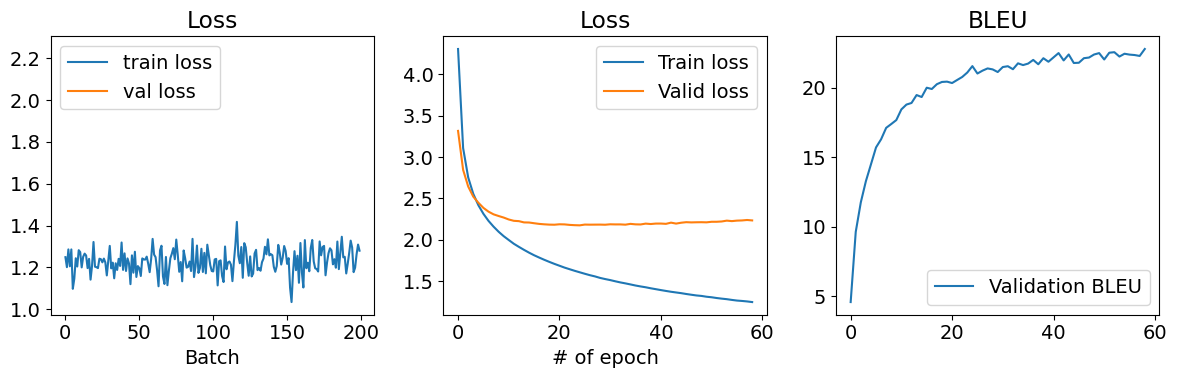

312it [00:14, 21.50it/s]


Epoch: 60 | Time: 0m 16s
	Train Loss: 1.239 | Train PPL:   3.452
	 Val. Loss: 2.236 |  Val. PPL:   9.359


In [64]:
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model,
                       optimizer,
                       criterion,
                       CLIP,
                       None, n_show,
                       train_history,
                       valid_history,
                       bleu_scores)
    valid_loss = evaluate(model, val_loader, criterion)
    bleu_score, _1, _2 = calc_bleu(model, val_loader)    

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss and valid_loss < 2.3:
        best_valid_loss = valid_loss
        state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()}
        torch.save(state, save_file)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_scores.append(bleu_score)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')


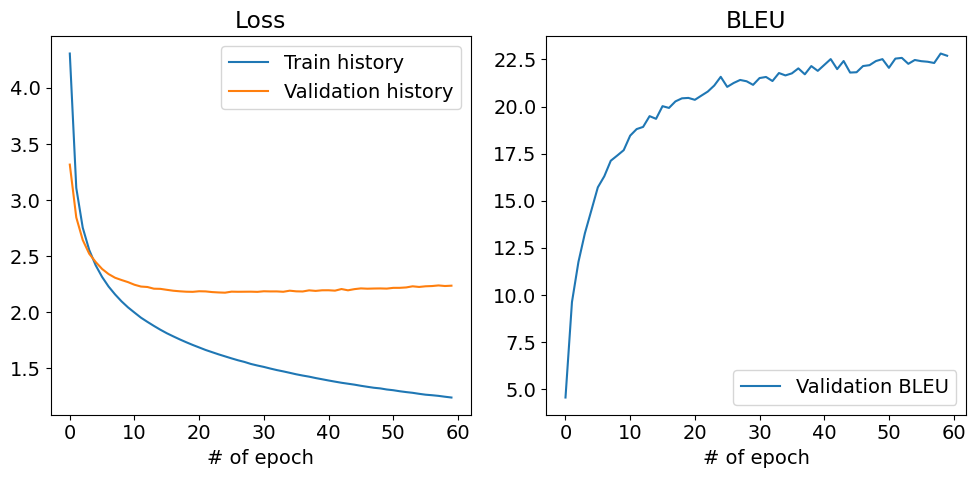

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(train_history, label='Train history')
ax[0].plot(valid_history, label='Validation history')
ax[0].set_xlabel('# of epoch')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(bleu_scores, label='Validation BLEU')
ax[1].set_xlabel('# of epoch')
ax[1].set_title('BLEU')
ax[1].legend()
fig.tight_layout()
plt.show()

In [66]:
test_loss = evaluate(model, test_loader, criterion)
print('Test loss:', test_loss)

Test loss: 2.2249029435609518


In [67]:
# Calculate BLEU score
bleu_score, translated_sentences, target_sentences = calc_bleu(model, test_loader)
print("BLEU Score:", bleu_score)

BLEU Score: 22.907607178682955


# Archive

In [97]:
def sentence2tokens(sentence, lang='en'):
    return wordpunct_tokenize(sentence.lower())

def tokens2indices(tokens, lang='en'):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    return [vocab['<SOS>']] + [vocab.lookup_indices(tokens)] + [vocab['<EOS>']]

def indices2tensor(indices, lang='en'):
    return torch.tensor(indices, dtype=torch.long).view(1, -1)

def indices2tokens(indices, lang='en', remove_specials=True):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    tokens = []
    if remove_specials:
        for idx in indices:
            if idx == UNK_IDX or idx > 3:
                tokens.append(english_vocab.lookup_token(idx))
            elif idx == EOS_IDX:
                break
        return tokens
    else:
        return vocab.lookup_tokens(indices)

def tokens2sentence(tokens, lang='en'):
    return "".join(tokens)

def translate_tensor_to_tensor(model, input):
    input = input.unsqueeze(1)
    model.eval()
    with torch.no_grad():
        input = input.to(DEVICE)
        return model(input).argmax(dim=-1)

def translate_indices_to_indices(model, indices):
    input = indices2tensor(indices)
    return translate_tensor_to_tensor(model, input).detach().cpu().tolist()

def translate_tokens_to_tokens(tokens):
    indices = tokens2indices(tokens, lang='ru')
    translated_indices = translate_indices_to_indices(indices)
    return indices2tokens(translated_indices, lang='en')

def translate_tensor_to_tokens(model, input):
    indices = translate_tensor_to_tensor(model, input).detach().cpu().tolist()[0]
    return indices2tokens(indices)


def translate_batch(model, input):
    pass

In [ ]:
def indeces_from_sentence(sentence, lang='en'):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    return vocab.lookup_indeces(tokens)

def tensor_from_sentence(sentence, lang='en'):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    indeces = [vocab['<SOS>']] + indeces_from_sentence(sentence, lang) + [vocab['<EOS>']]
    return torch.tensor(indeces, dtype=torch.long).view(1, -1)


def tensor_from_tokens(tokens, lang='en'):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    indeces = [vocab['<SOS>']] + vocab.lookup_indeces(tokens) + [vocab['<EOS>']]
    return torch.tensor(indeces, dtype=torch.long).view(1, -1)

def tensor_from_indeces(indeces):
    torch.tensor(indeces, dtype=torch.long).view(1, -1)


def translate_sentence_to_indeces(model, input):
    input = tensorFromSentence(input, lang='ru')

    model.eval()
    with torch.no_grad():
        input = input.to(DEVICE)

        # Assuming your model returns token indices
        raw_indices = model(input).argmax(dim=-1)
        raw_indices = raw_indices.detach().cpu().tolist()
        translated_indices = []
        for idx in raw_indices:
            or idx in indices:
                if idx == UNK_IDX or idx > 3:
                    translated_indices.append(english_vocab.lookup_token(idx))
                elif idx == EOS_IDX:
                    break
    return translated_indices


def translate_tokens_to_tokens(model, tokens):


def translate_sentence_to_tokens(model, sentence):
    indeces = translate_sentence_to_indeces(model, sentence)
    return indices2tokens(indeces)

def translate_sentence_to_sentence(model, sentence):
    indeces = translate_sentence_to_indeces(model, sentence)
    tokens = indices2tokens(indeces)
    return tokens2sentence(tokens)